In [95]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.interpolate as interp
import astropy.units as u
from scipy.signal import butter, filtfilt, correlate, correlation_lags

In [79]:
os.listdir("./bt-settl/models_1671388423/bt-settl/")[:5]

['lte010-4.0-0.0.BT-Settl.7.dat.txt',
 'lte010-4.5-0.0.BT-Settl.7.dat.txt',
 'lte010-5.0-0.0.BT-Settl.7.dat.txt',
 'lte010-5.5-0.0.BT-Settl.7.dat.txt',
 'lte011-3.5-0.0.BT-Settl.7.dat.txt']

In [80]:
def get_filename_from_pars(Teff, logg, root_dir="./bt-settl/models_1671388423/bt-settl/"):
    """
    Get the filename for the BT-Settl model with the given effective temperature and surface gravity.
    Assume metallicity to be zero.
    root_dir is the path to the directory containing the BT-Settl models.
    """
    # The BT-Settl filenames are of the form "lte{teff:05d}-{logg:4.2f}.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits"
    # where the effective temperature is in Kelvin and the surface gravity is in log10(cm/s^2).
    # The surface gravity is rounded to the nearest 0.5.
    return root_dir + \
        "lte0{:1d}-{:3.1f}-0.0.BT-Settl.7.dat.txt".format(int(np.round(Teff/100)), np.round(logg, 1))

get_filename_from_pars(1000, 4.5)

'./bt-settl/models_1671388423/bt-settl/lte010-4.5-0.0.BT-Settl.7.dat.txt'

In [81]:
# parse data file with two columns
# ignorning lines starting with #
# and return result as two numpy arrays
def parse_data_file(filename):
    data = np.loadtxt(filename, comments='#')
    return data[:,0] * u.Angstrom, data[:,1] * u.Unit('erg cm-2 s-1 Angstrom-1')

parse_data_file(get_filename_from_pars(1000, 4.5))

(<Quantity [0.00000e+00, 1.00000e-03, 2.00000e-03, ..., 9.98227e+06,
            9.98727e+06, 9.99227e+06] Angstrom>,
 <Quantity [2.11349e-97, 2.11349e-97, 2.11349e-97, ..., 2.22844e-06,
            2.45132e-06, 2.63330e-06] erg / (Angstrom cm2 s)>)

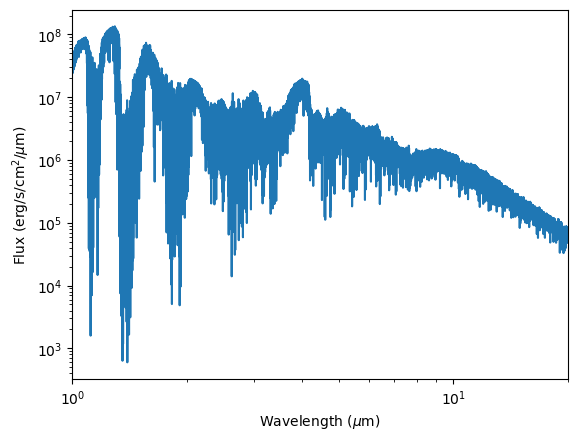

In [82]:
# plot the data from parse_data_file
low_wv, upp_wv = 1 * u.micron, 20 * u.micron
wvs, flux = parse_data_file(get_filename_from_pars(1000, 4.5))
wvs, flux = wvs.to("micron"), flux.to("erg/s/cm^2/micron")
wvs, flux = wvs[low_wv < wvs], flux[low_wv < wvs]
wvs, flux = wvs[wvs < upp_wv], flux[wvs < upp_wv]
plt.figure()
plt.xlim([1,20])
plt.plot(wvs, flux)
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Flux (erg/s/cm$^2$/$\mu$m)")
plt.loglog()
plt.show() 
plt.close()

# $\beta$ Pictoris b

In [83]:
# parse a csv file with several columns, keep data from first two columns, return it as arrays
def parse_csv_file(filename, xunit, yunit):
    data = np.loadtxt(filename, delimiter=',', usecols=(0,1))
    return np.sort(data[:,0]) * xunit, data[:,1][np.argsort(data[:,0])] * yunit

parse_csv_file("./measurements/betaPic_gravity.csv", u.micron, 1e-15 * u.Unit('W m-2 micron-1'))

(<Quantity [1.97002372, 1.97200749, 1.97453173, 1.97651397, 1.97875198,
            1.98099   , 1.98311175, 1.98529164, 1.98756702, 1.98987475,
            1.99189797, 1.9942354 , 1.99569696, 1.9985049 , 2.00081242,
            2.00299231, 2.00513776, 2.00768212, 2.00973251, 2.01168278,
            2.01411872, 2.01615881, 2.01846633, 2.02046657, 2.02287286,
            2.02507326, 2.02724232, 2.02935438, 2.03187059, 2.03372932,
            2.03598124, 2.03821925, 2.04032938, 2.04242781, 2.04463576,
            2.04705505, 2.04904394, 2.05129718, 2.05329455, 2.05576159,
            2.05854305, 2.06051619, 2.06251656, 2.06450331, 2.06718556,
            2.06928988, 2.07118202, 2.07348398, 2.07529778, 2.07801325,
            2.08010211, 2.08195272, 2.08457814, 2.08661824, 2.0891123 ,
            2.09103978, 2.0933912 , 2.0954485 , 2.09776264, 2.09992453,
            2.10194693, 2.10423841, 2.1065427 , 2.10860927, 2.11076659,
            2.11298013, 2.11536424, 2.11755461, 2.11974695, 2.12

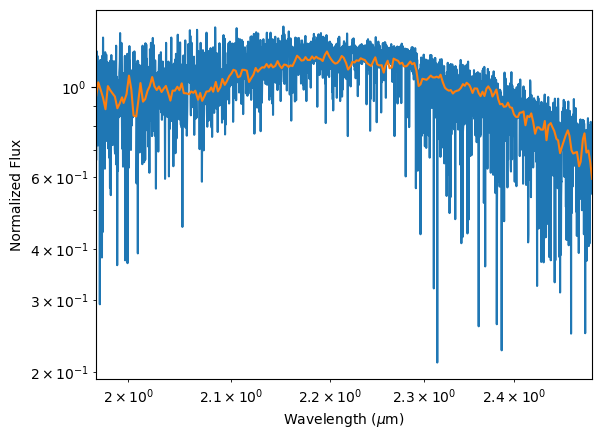

In [84]:
wvs_grav, flux_grav = parse_csv_file("./measurements/betaPic_gravity.csv", u.micron, 1e-15 * u.Unit('W m-2 micron-1'))
flux_grav = flux_grav / np.nanmean(flux_grav)
low_wv, upp_wv = np.nanmin(wvs_grav), np.nanmax(wvs_grav)
wvs, flux = parse_data_file(get_filename_from_pars(1700, 4.0))
wvs, flux = wvs.to("micron"), flux.to("erg/s/cm^2/micron")
wvs, flux = wvs[low_wv < wvs], flux[low_wv < wvs]
wvs, flux = wvs[wvs < upp_wv], flux[wvs < upp_wv]
flux = flux / np.nanmean(flux)
plt.figure()
plt.xlim([low_wv.to("micron").value, upp_wv.to("micron").value])
plt.plot(wvs, flux)
plt.plot(wvs_grav, flux_grav)
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Normalized Flux")
plt.loglog()
plt.show() 
plt.close()

In [85]:
# input an numpy array of wavelengths and fluxes and bin centers, 
# return moving average for each bin center
def moving_average(wvs, flux, bin_centers):
    bin_flux = np.zeros(len(bin_centers))
    for i in range(len(bin_centers)):
        if i == 0:
            bin_flux[i] = np.nanmean(flux[(wvs < ((bin_centers[i]+bin_centers[i+1]) / 2))])
        elif i == len(bin_centers)-1:
            bin_flux[i] = np.nanmean(flux[(wvs > ((bin_centers[i]+bin_centers[i-1]) / 2))])
        else:
            upp, low = (bin_centers[i]+bin_centers[i+1]) / 2, (bin_centers[i]+bin_centers[i-1]) / 2
            bin_flux[i] = np.nanmean(flux[(wvs > low) & (wvs < upp)])
    return bin_centers, bin_flux 

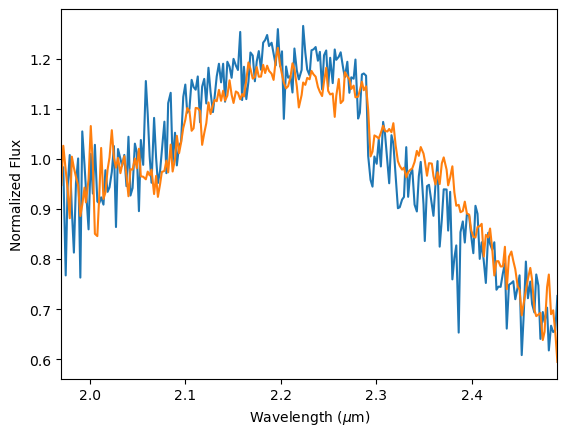

In [86]:
wvs_avg, flux_avg = moving_average(wvs, flux, wvs_grav)
flux_avg = flux_avg / np.nanmean(flux_avg)
plt.figure()
plt.xlim([low_wv.to("micron").value, upp_wv.to("micron").value])
plt.plot(wvs_avg, flux_avg)
plt.plot(wvs_grav, flux_grav)
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Normalized Flux")
plt.show() 
plt.close()

In [87]:
# high pass filter the numpy array of fluxes using scipy.signal.butter
def high_pass_filter(flux, cutoff, order):
    b, a = butter(order, cutoff, btype='highpass', analog=False)
    return filtfilt(b, a, flux)

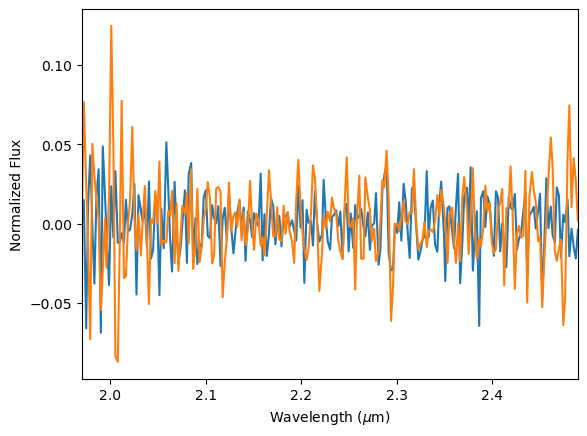

In [91]:
plt.figure()
plt.xlim([low_wv.to("micron").value, upp_wv.to("micron").value])
flux_avg, flux_grav = high_pass_filter(flux_avg, 0.1, 2), high_pass_filter(flux_grav, 0.1, 2)
plt.plot(wvs_avg, flux_avg)
plt.plot(wvs_grav, flux_grav)
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Normalized Flux")
plt.show() 
plt.close()